<a href="https://colab.research.google.com/github/djbradyAtOpticalSciencesArizona/computationalImaging/blob/master/inverseProblems/lassoAndTVRegression.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>


# Lasso and TV Regression
###David Brady
### University of Arizona

Section 3.4 of **Computational Imaging**

This notebook considers  estimators for $\mathbf{f}$ from
\begin{equation} 
    \mathbf{f}_e 
    = 
    {\rm arg} \min_{\mathbf{f}_e }\left \lbrace
         \| \mathbf{g}-\mathbf{H}\mathbf{f}_e\|_2+ \lambda_o^2\gamma\left
    (\mathbf{f}_e\right )
 \right\rbrace
\end{equation} 
specifically for the case of Lasso and TV constraints.

### Python modules

In [6]:
import numpy as np
import matplotlib.pyplot as plt
from google.colab import files
from scipy.linalg import toeplitz
%matplotlib inline
plt.rcParams['figure.figsize'] = [30, 10]
plt.rcParams.update({'font.size': 22})
from sklearn import linear_model
from skimage import filters


### Installation of the Chianti database of astrophysical data

CHIANTI consists of a database of atomic data that can be used to interpret spectral lines and continua emitted from high-temperature, optically-thin astrophysical sources. For more information see [the database github page](https://chianti-atomic.github.io/index.html) We use the database here to generate example 1D signals

In [ ]:
!wget https://download.chiantidatabase.org/CHIANTI_10.0.1_database.tar.gz
!mkdir dbase
!tar xvf CHIANTI_10.0.1_database.tar.gz -C dbase/

--2021-07-31 08:52:42--  https://download.chiantidatabase.org/CHIANTI_10.0.1_database.tar.gz
Resolving download.chiantidatabase.org (download.chiantidatabase.org)... 70.32.23.63
Connecting to download.chiantidatabase.org (download.chiantidatabase.org)|70.32.23.63|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 888202017 (847M) [application/x-gzip]
Saving to: ‘CHIANTI_10.0.1_database.tar.gz’

CHIANTI_10.0.1_data 100%[===================>] 847.05M  88.3MB/s    in 10s     

2021-07-31 08:52:53 (84.4 MB/s) - ‘CHIANTI_10.0.1_database.tar.gz’ saved [888202017/888202017]

README_CHIANTI
VERSION
abundance/
abundance/sun_coronal_2012_schmelz_ext.abund
abundance/cosmic_1973_allen.abund
abundance/sun_photospheric_2011_caffau.abund
abundance/sun_photospheric_2015_scott.abund
abundance/unity.abund
abundance/sun_coronal_1999_fludra_ext.abund
abundance/sun_photospheric_1998_grevesse.abund
abundance/sun_coronal_1992_feldman_ext.abund
abundance/sun_coronal_1999_fludra.abund
ab

In [ ]:
!pip3 install ChiantiPy
!pip3 install ipyparallel
%env XUVTOP=/content/dbase/

     |████████████████████████████████| 189 kB 5.1 MB/s 
     |████████████████████████████████| 199 kB 5.0 MB/s 
env: XUVTOP=/content/dbase/


In [ ]:
import ChiantiPy.core as ch

 ChiantiPy version 0.11.0 
 using cli
 using CLI for selections


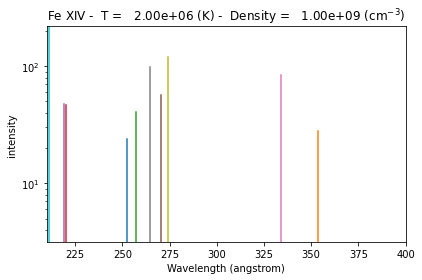

In [ ]:
t=2000000
fe14 = ch.ion('fe_14', temperature=t, eDensity=1.e+9, em=1.e+27)
fe14.intensityPlot(wvlRange=[210.,400.],linLog='log')
wvl = np.linspace(100,400,1024)
fe14.spectrum(wvl)

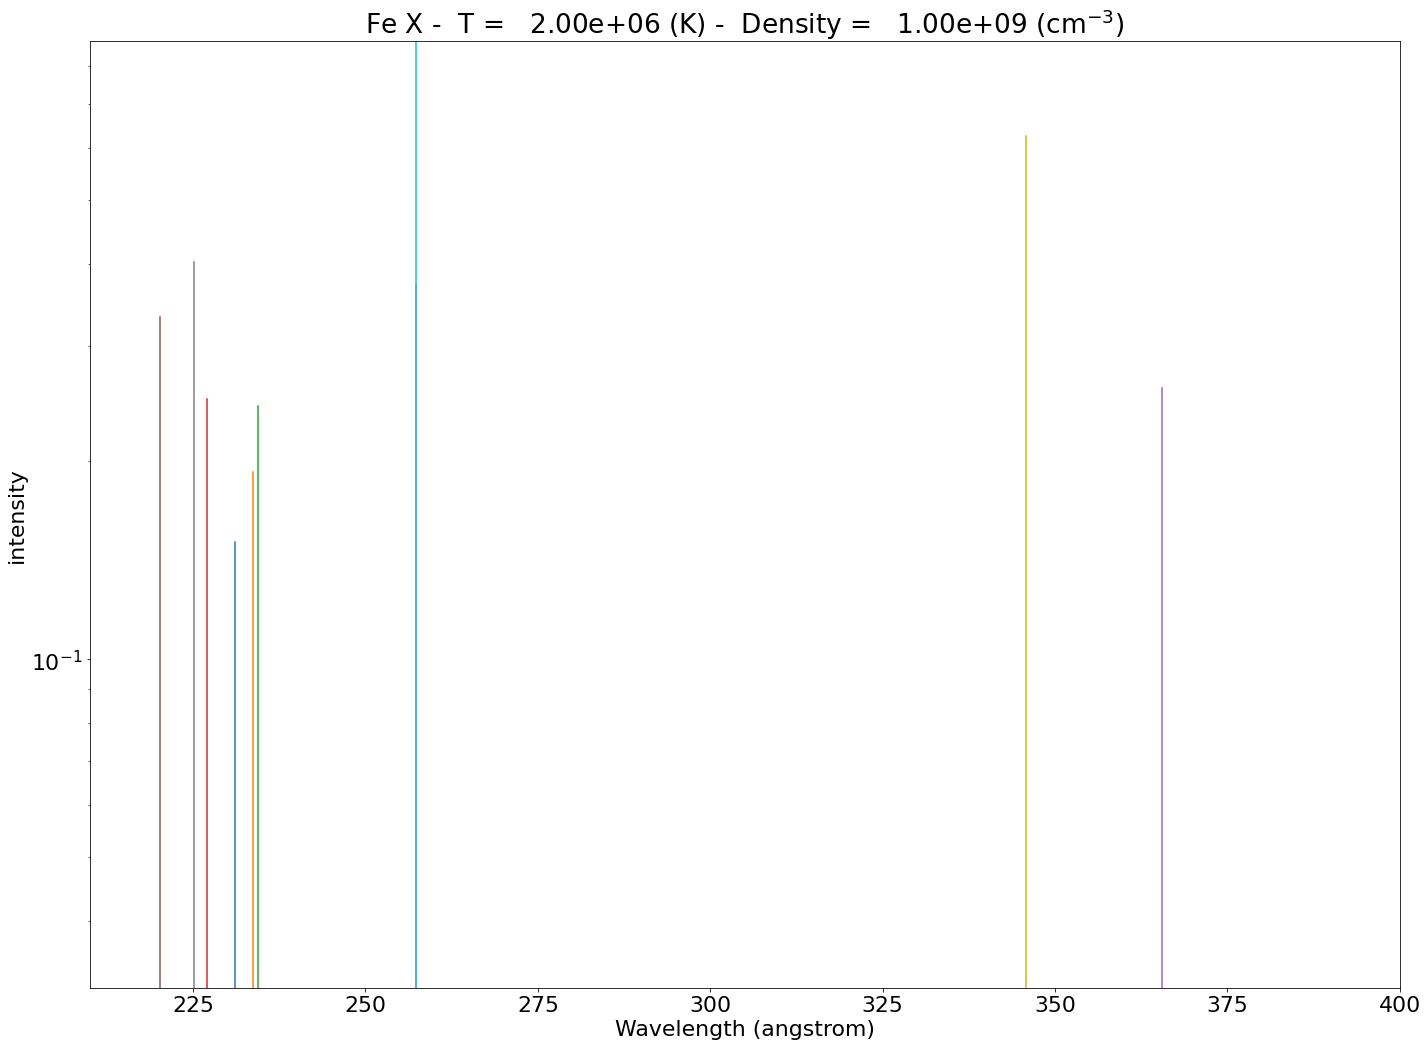

In [ ]:
t=2000000
fe10 = ch.ion('fe_10', temperature=t, eDensity=1.e+9, em=1.e+27)
fe10.intensityPlot(wvlRange=[210.,400.],linLog='log')
wvl = np.linspace(100,400,1024)
fe10.spectrum(wvl)

##  Lasso regression on a compressively sampled sparse signal

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

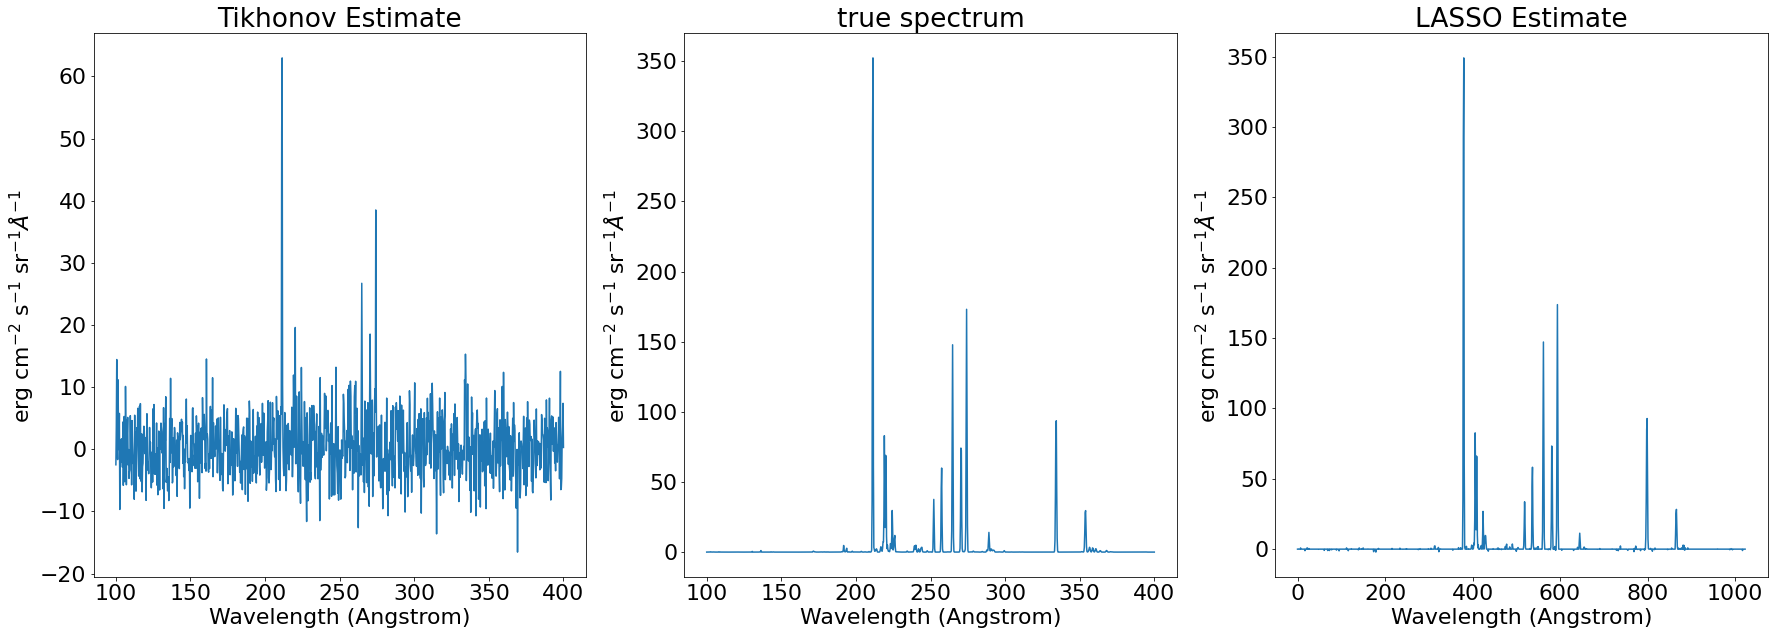

In [ ]:
#
# We are considering measurements of length 1024 spectra using $m\times 1024 $ random matricies
#
R=400
noiseLevel=3
H=np.random.random((R,1024))-.5
y=np.matmul(H,fe14.Spectrum['intensity'])+noiseLevel*np.random.normal(scale=1,size=(R))
plt.subplot(1,3,1)
#fe=np.linalg.lstsq(H, y)[0]
lpam=10
fe=np.matmul(np.matmul(np.linalg.pinv(np.matmul(np.transpose(H),H)+lpam**2*np.eye(1024)),np.transpose(H)), y)
plt.plot(wvl,fe)
plt.xlabel(fe14.Spectrum['xlabel'])
plt.ylabel(fe14.Spectrum['ylabel'])
plt.title('Tikhonov Estimate')
plt.subplot(1,3,2)
plt.plot(wvl,fe14.Spectrum['intensity'])
plt.xlabel(fe14.Spectrum['xlabel'])
plt.ylabel(fe14.Spectrum['ylabel'])
plt.title('true spectrum')
model = linear_model.Lasso(alpha=0.1)
model.fit(H,y)
fe=model.coef_
plt.subplot(1,3,3)
plt.plot(fe)
plt.xlabel(fe14.Spectrum['xlabel'])
plt.ylabel(fe14.Spectrum['ylabel'])
plt.title('LASSO Estimate')
plt.savefig('lasso.pdf')
files.download('lasso.pdf')

### TV denoising

In [2]:
!wget --no-check-certificate --content-disposition 'https://github.com/djbradyAtOpticalSciencesArizona/computationalImaging/raw/master/images/snake.npy'

--2021-09-07 19:34:02--  https://github.com/djbradyAtOpticalSciencesArizona/computationalImaging/raw/master/images/snake.npy
Resolving github.com (github.com)... 140.82.114.4
Connecting to github.com (github.com)|140.82.114.4|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://raw.githubusercontent.com/djbradyAtOpticalSciencesArizona/computationalImaging/master/images/snake.npy [following]
--2021-09-07 19:34:03--  https://raw.githubusercontent.com/djbradyAtOpticalSciencesArizona/computationalImaging/master/images/snake.npy
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.110.133, 185.199.111.133, 185.199.109.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.110.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 8388736 (8.0M) [application/octet-stream]
Saving to: ‘snake.npy’

snake.npy           100%[===================>]   8.00M  --.-KB/s    in 0.09s   

2021-09-0

Text(0.5, 1.0, 'TV Restored')

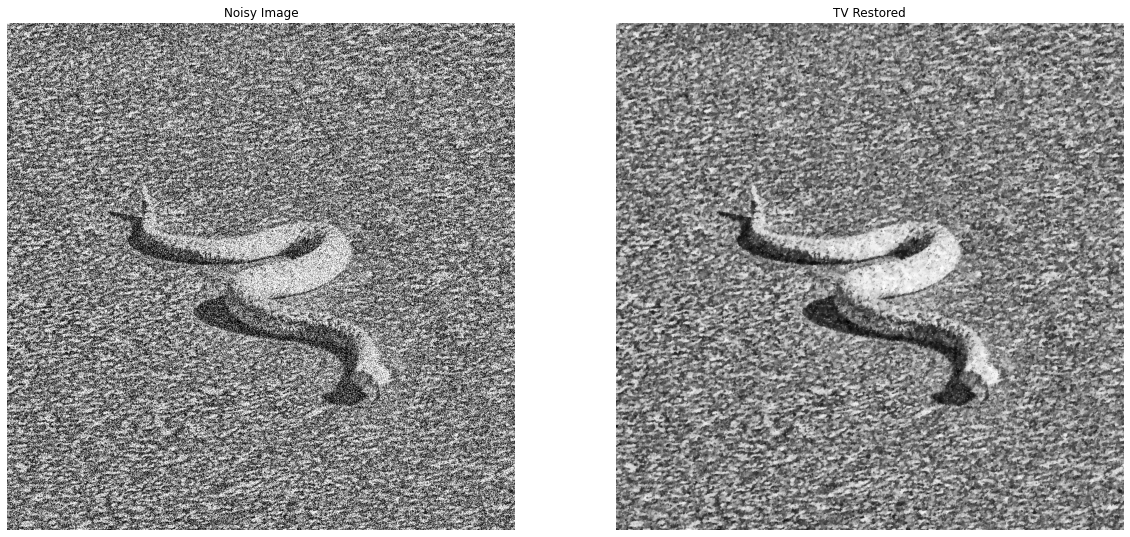

In [3]:
from skimage.restoration import denoise_tv_chambolle
from skimage import color, data, restoration, exposure, filters
from skimage.util import random_noise
snake=np.load('snake.npy')
snake=exposure.equalize_adapthist(snake)

sigma = .5
snake = random_noise(snake, var=sigma**2)
denoised = denoise_tv_chambolle(snake, weight=0.2)
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(20, 10),
                       sharex=True, sharey=True)

plt.gray()

ax[0].imshow(snake)
ax[0].axis('off')
ax[0].set_title('Noisy Image')
ax[1].imshow(denoised)
ax[1].axis('off')
ax[1].set_title('TV Restored')

#plt.savefig('snakeTV.pdf')
#files.download('snakeTV.pdf')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

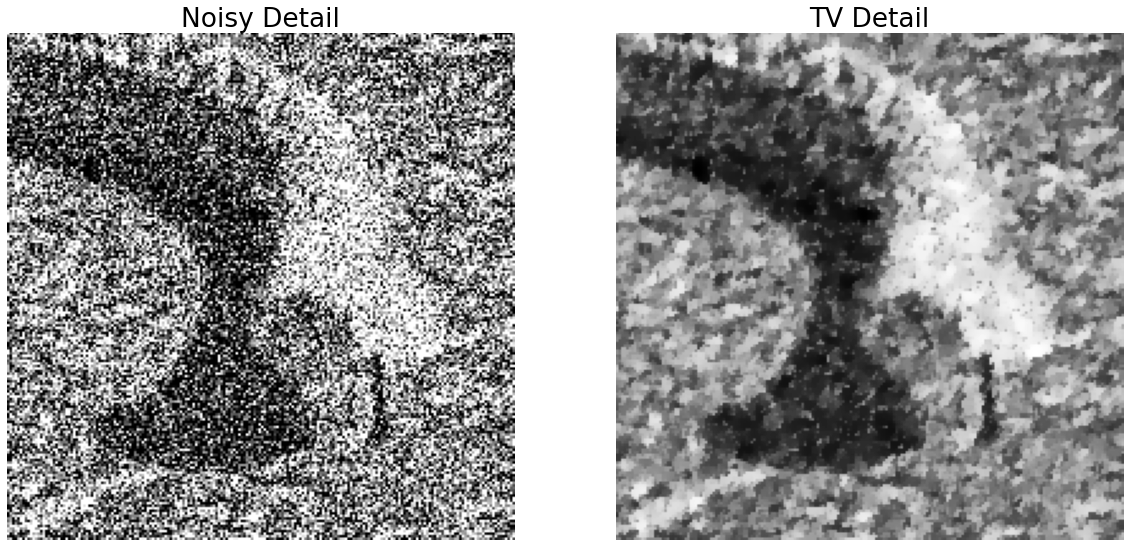

In [ ]:
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(20, 10),
                       sharex=True, sharey=True)

plt.gray()

ax[0].imshow(snake[600:800,600:800])
ax[0].axis('off')
ax[0].set_title('Noisy Detail')
ax[1].imshow(denoised[600:800,600:800])
ax[1].axis('off')
ax[1].set_title('TV Detail')

plt.savefig('snakeTVDetail.pdf')
files.download('snakeTVDetail.pdf')

(-0.5, 1023.5, 1023.5, -0.5)

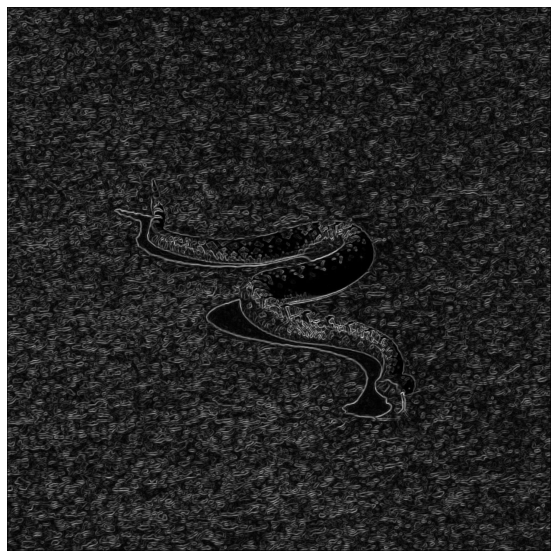

In [9]:
snake=np.load('snake.npy')
plt.imshow(filters.roberts(snake))
plt.axis('off')